In [2]:
# !pip install lightning

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# %cd /content/gdrive/MyDrive/Colab Notebooks
# %mkdir ClassPreTreined
# %cd /content/gdrive/MyDrive/Colab Notebooks/ClassPreTreined
# %mkdir weights

%cd /content/gdrive/MyDrive/Colab Notebooks/ClassPreTreined/weights

/content/gdrive/MyDrive/Colab Notebooks/ClassPreTreined/weights


In [5]:
import os
import numpy as np
from numpy import random

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchmetrics
from torchvision import datasets, models
from torchvision.transforms import v2
from torchsummary import summary

from torch.utils.data import DataLoader, SubsetRandomSampler

import lightning.pytorch as pl
from lightning.pytorch.loggers import TensorBoardLogger, CSVLogger
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch import Trainer, LightningModule

RANDOM_SEED = 546

pl.seed_everything(RANDOM_SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

INFO: Seed set to 546
INFO:lightning.fabric.utilities.seed:Seed set to 546


## DataSet

In [6]:
pl.seed_everything(RANDOM_SEED)

image_transforms = {
    'train': v2.Compose([
    v2.Pad(4),
    v2.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.5, 1.25), shear=5, interpolation=v2.InterpolationMode.BILINEAR),
    v2.ColorJitter(brightness=(0.1, 0.5), contrast=(0.1, 0.5)),
    v2.Lambda(lambda x: x.convert("RGB")),
    v2.Resize((132, 132)),
    v2.RandomCrop(size=(128, 128)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True), # transform.ToTensor()
    v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]),
    'test': v2.Compose([
    v2.Lambda(lambda x: x.convert("RGB")),
    v2.Resize((132, 132)),
    v2.RandomCrop(size=(128, 128)),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
}

INFO: Seed set to 546
INFO:lightning.fabric.utilities.seed:Seed set to 546


In [7]:
pl.seed_everything(RANDOM_SEED)

route = os.getcwd()
print(route)

train_dataset = datasets.MNIST(root=route,
                                train=True,
                                transform = image_transforms['train'],
                                download=True)

test_dataset = datasets.MNIST(root=route,
                              train=False,
                              transform = image_transforms['test'])

INFO: Seed set to 546
INFO:lightning.fabric.utilities.seed:Seed set to 546


/content/gdrive/MyDrive/Colab Notebooks/ClassPreTreined/weights


In [8]:
pl.seed_everything(RANDOM_SEED)

VALIDATION_FRACTION = 0.2
TEST_SAMPLE = 1500

n_sample = train_dataset.__len__()
n_sample_test = test_dataset.__len__()

if VALIDATION_FRACTION is not None:
  num = int(VALIDATION_FRACTION * n_sample)

  train_indices = torch.arange(0, n_sample  - num)
  valid_indices = torch.arange(n_sample  - num, n_sample )
  test_indices = torch.arange(0, TEST_SAMPLE)

  indices = torch.arange(0, n_sample)
  shuffled_tensor = indices[torch.randperm(indices.size(0))]

  indices_test = torch.arange(0, n_sample_test)
  shuffled_tensor_test = indices_test[torch.randperm(indices_test.size(0))]

  train_sampler = SubsetRandomSampler(shuffled_tensor[train_indices])
  valid_sampler = SubsetRandomSampler(shuffled_tensor[valid_indices])
  test_sampler = SubsetRandomSampler(shuffled_tensor_test[test_indices])

  print('Train size: ', len(train_sampler))
  print('Valid size: ', len(valid_sampler))
  print('Test size: ', len(test_sampler))

INFO: Seed set to 546
INFO:lightning.fabric.utilities.seed:Seed set to 546


Train size:  48000
Valid size:  12000
Test size:  1500


In [9]:
pl.seed_everything(RANDOM_SEED)

BATCH_SIZE = 32
NUM_WORKERS = 8

train_loader = DataLoader(dataset=train_dataset,
                          batch_size= BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          drop_last=True,
                          sampler=train_sampler)

valid_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          sampler=valid_sampler,
                          shuffle=False)

test_loader = DataLoader(dataset=test_dataset,
                          batch_size=1,
                          num_workers=NUM_WORKERS,
                          sampler=test_sampler,
                          shuffle=False)

print("Size of Train DataLoader:", len(train_loader))
print("Size of Valid DataLoader:", len(valid_loader))
print("Size of Test DataLoader:", len(test_loader))

INFO: Seed set to 546
INFO:lightning.fabric.utilities.seed:Seed set to 546


Size of Train DataLoader: 1500
Size of Valid DataLoader: 375
Size of Test DataLoader: 1500


INFO: Seed set to 546
INFO:lightning.fabric.utilities.seed:Seed set to 546


Image batch dimensions: torch.Size([32, 3, 128, 128])
Image label dimensions: torch.Size([32])


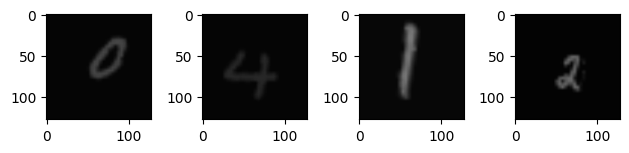

In [11]:
# Checking the dataset
pl.seed_everything(RANDOM_SEED)

for batch in valid_loader:
    images, labels = batch
    # print(np.unique(images))
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

fig, ax = plt.subplots(1, 4)

for i in range(4):
  img = v2.ToPILImage()(images[i])
  ax[i].imshow(img)

plt.tight_layout()



INFO: Seed set to 546
INFO:lightning.fabric.utilities.seed:Seed set to 546


Image batch dimensions: torch.Size([1, 3, 128, 128])
Image label dimensions: torch.Size([1])


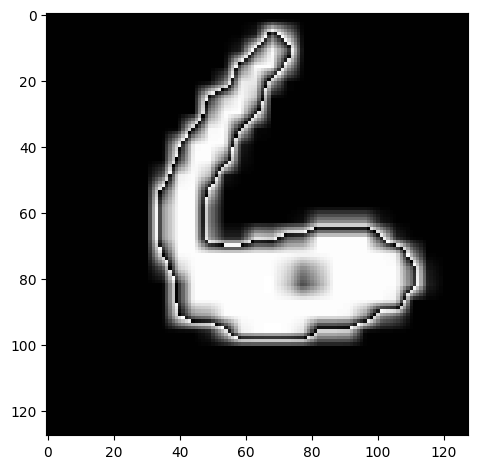

In [12]:
# Checking the dataset
pl.seed_everything(RANDOM_SEED)

for batch in test_loader:
    images, labels = batch
    # print(np.unique(images))
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

img = v2.ToPILImage()(images[0])
plt.imshow(img)
plt.tight_layout()


## Deep learning Models

In [14]:
weights = models.RegNet_Y_400MF_Weights.DEFAULT
model = models.regnet_y_400mf(weights=weights)
input_size = (3, 128, 128)
summary(model, input_size, device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             864
       BatchNorm2d-2           [-1, 32, 64, 64]              64
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 48, 32, 32]           1,536
       BatchNorm2d-5           [-1, 48, 32, 32]              96
            Conv2d-6           [-1, 48, 64, 64]           1,536
       BatchNorm2d-7           [-1, 48, 64, 64]              96
              ReLU-8           [-1, 48, 64, 64]               0
            Conv2d-9           [-1, 48, 32, 32]           3,456
      BatchNorm2d-10           [-1, 48, 32, 32]              96
             ReLU-11           [-1, 48, 32, 32]               0
AdaptiveAvgPool2d-12             [-1, 48, 1, 1]               0
           Conv2d-13              [-1, 8, 1, 1]             392
             ReLU-14              [-1, 

In [17]:
for index, (name, param) in enumerate(model.named_parameters()):
  if "fc" in name:
    param.requires_grad = True
  else:
    param.requires_grad = False

NUM_CLASSES = 10
model.fc = torch.nn.Linear(model.fc.in_features, NUM_CLASSES)

summary(model, input_size, device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             864
       BatchNorm2d-2           [-1, 32, 64, 64]              64
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 48, 32, 32]           1,536
       BatchNorm2d-5           [-1, 48, 32, 32]              96
            Conv2d-6           [-1, 48, 64, 64]           1,536
       BatchNorm2d-7           [-1, 48, 64, 64]              96
              ReLU-8           [-1, 48, 64, 64]               0
            Conv2d-9           [-1, 48, 32, 32]           3,456
      BatchNorm2d-10           [-1, 48, 32, 32]              96
             ReLU-11           [-1, 48, 32, 32]               0
AdaptiveAvgPool2d-12             [-1, 48, 1, 1]               0
           Conv2d-13              [-1, 8, 1, 1]             392
             ReLU-14              [-1, 

In [16]:
pl.seed_everything(RANDOM_SEED)

class LightningModel(pl.LightningModule):
    def __init__(self, model, optimizer_name, optimizer_hparams):
        """LightningModel.
        Args:
            model: Name of the model/CNN to run. Used for creating the model
            optimizer_name: Name of the optimizer to use. Currently supported: Adam, SGD
            optimizer_hparams: Hyperparameters for the optimizer, as dictionary. This includes learning rate, weight decay, etc.
         """
        super().__init__()

        self.model = model
        self.save_hyperparameters(ignore=['model'])

        # Set up attributes for computing the accuracy
        self.train_acc = torchmetrics.Accuracy(task='multiclass', num_classes=NUM_CLASSES)
        self.valid_acc = torchmetrics.Accuracy(task='multiclass', num_classes=NUM_CLASSES)
        self.test_acc = torchmetrics.Accuracy(task='multiclass', num_classes=NUM_CLASSES)

    # Defining the forward method is only necessary
    # if you want to use a Trainer's .predict() method (optional)
    def forward(self, x):
        return self.model(x)

    # A common forward step to compute the loss and labels
    # this is used for training, validation, and testing below
    def _shared_step(self, batch):
        features, true_labels = batch
        logits = self(features)
        loss = torch.nn.functional.cross_entropy(logits, true_labels)
        predicted_labels = torch.argmax(logits, dim=1)

        return loss, true_labels, predicted_labels

    def training_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.train_acc.update(predicted_labels, true_labels)
        metrics = {'train_loss': loss, 'train_acc': self.train_acc}
        self.log_dict(metrics, on_epoch=True, on_step=False, prog_bar=True)
        return loss  # this is passed to the optimzer for training

    def validation_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.valid_acc(predicted_labels, true_labels)
        metrics = {'valid_loss': loss, 'valid_acc': self.valid_acc}
        self.log_dict(metrics, on_epoch=True, on_step=False, prog_bar=True)

    def test_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.test_acc(predicted_labels, true_labels)
        metrics = {'test_loss': loss, 'test_acc': self.test_acc}
        self.log_dict(metrics, on_epoch=True, on_step=False, prog_bar=True)

    def configure_optimizers(self):
      # We will support Adam or SGD as optimizers.
      if self.hparams.optimizer_name == "Adam":
          optimizer = torch.optim.AdamW(self.parameters(), **self.hparams.optimizer_hparams)
      elif self.hparams.optimizer_name == "SGD":
          optimizer = torch.optim.SGD(self.parameters(), **self.hparams.optimizer_hparams)
      else:
          assert False, f'Unknown optimizer: "{self.hparams.optimizer_name}"'

      # scheduler = torch.optim.swa_utils.SWALR(optimizer, anneal_strategy="cos", anneal_epochs=5, swa_lr=0.002)
      scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5)
      return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "valid_loss"}

INFO: Seed set to 546
INFO:lightning.fabric.utilities.seed:Seed set to 546


In [18]:
pl.seed_everything(RANDOM_SEED)

optimizer_name = "Adam"
optimizer_hparams = {"lr": 0.00003, "betas": (0.9, 0.999), "eps": 1e-08, "weight_decay": 0.01, "amsgrad": False}

model_light = LightningModel(model, optimizer_name, optimizer_hparams)

arch = 'regnet_y_400m'

cbs = ModelCheckpoint(dirpath = f'./checkpoints_{arch}',
                                   filename = arch,
                                   verbose = True,
                                   monitor = 'valid_loss',
                                   mode = 'min')

logger_csv = CSVLogger(save_dir="logs/", name="my-model")

INFO: Seed set to 546
INFO:lightning.fabric.utilities.seed:Seed set to 546


In [19]:
pl.seed_everything(RANDOM_SEED)

PERCENT_VALID_EXAMPLES = 1
EPOCHS = 20
LOG_EVERY_N_STEPS = 1

trainer = pl.Trainer(
    limit_val_batches = PERCENT_VALID_EXAMPLES,
    max_epochs = EPOCHS,
    logger=logger_csv,
    callbacks = cbs,
    log_every_n_steps=LOG_EVERY_N_STEPS,
    accelerator="auto",  # Uses GPUs or TPUs if available
    devices="auto",  # Uses all available GPUs/TPUs if applicable

)

# trainer.fit(model_light, train_dataloaders = train_loader, val_dataloaders=valid_loader)

INFO: Seed set to 546
INFO:lightning.fabric.utilities.seed:Seed set to 546
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: `Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.


In [ ]:
# run test dataset
test_metrics = trainer.test(model_light, dataloaders=test_loader, verbose=False)
print(test_metrics)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

[{'test_loss': 3.5914242267608643, 'test_acc': 0.24933333694934845}]


## Load the model from the checkpoint

In [20]:
# If you are working in GPU, please, you do not run: device = torch.device('cpu')
device = torch.device('cpu')
checkpoint_file = '/content/gdrive/MyDrive/Colab Notebooks/ClassPreTreined/weights/checkpoints_regnet_y_400m/regnet_y_400m.ckpt'

pl.seed_everything(RANDOM_SEED)

optimizer_name = "Adam"
optimizer_hparams = {"lr": 0.00003, "betas": (0.9, 0.999), "eps": 1e-08, "weight_decay": 0.01, "amsgrad": False}

model_light = LightningModel(model, optimizer_name, optimizer_hparams)

checkpoint = torch.load(checkpoint_file, map_location=device)
model_light.load_state_dict(checkpoint['state_dict'])

INFO: Seed set to 546
INFO:lightning.fabric.utilities.seed:Seed set to 546


<All keys matched successfully>

<Axes: xlabel='Epoch', ylabel='ACC'>

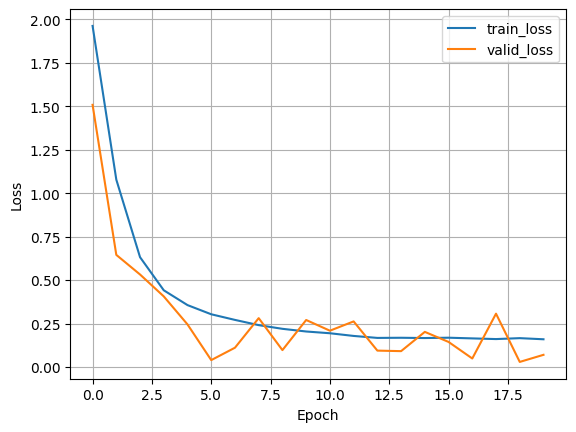

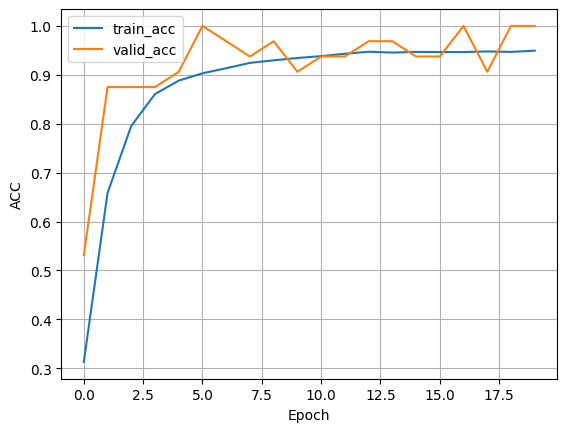

In [21]:
import pandas as pd

def printdf(df):
  return display(pd.DataFrame(df))

path = '/content/gdrive/MyDrive/Colab Notebooks/ClassPreTreined/weights/logs/my-model/version_0'
metrics = pd.read_csv(f"{path}/metrics.csv")
metrics

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)

df_metrics[["train_loss", "valid_loss"]].plot(grid=True, legend=True, xlabel='Epoch', ylabel='Loss')
df_metrics[["train_acc", "valid_acc"]].plot(grid=True, legend=True, xlabel='Epoch', ylabel='ACC')

## This cell must be run if it is the first time.

### The results can called from the predict folder.

In [ ]:
pl.seed_everything(RANDOM_SEED)

target_list = []
predict_list = []
prob_predict_list = []

for idx, batch in enumerate(test_loader):
    images, targets = batch
    with torch.no_grad():
      model.eval()
      logits = model(images)

    prob_predict = logits.sigmoid()

    pr_masks = torch.argmax(logits, 1).unsqueeze(1)

    target = targets[0].cpu().numpy().astype(int)
    target_predict = pr_masks[0][0].cpu().numpy().astype(int)

    target_list.append(target)
    predict_list.append(target_predict)
    prob_predict_list.append(prob_predict)
    # if idx == 3:
    #   break

target_ = np.vstack(target_list)
predict_ = np.vstack(predict_list)
prob_predict_ = np.vstack(prob_predict_list)

INFO: Seed set to 546
INFO:lightning.fabric.utilities.seed:Seed set to 546


## It will call the results saved from the previous cell in folder

In [22]:
# %mkdir predict

path = '/content/gdrive/MyDrive/Colab Notebooks/ClassPreTreined/weights/predict'

# np.save(f'{path}/target.npy', target_)
# np.save(f'{path}/predict.npy', predict_)
# np.save(f'{path}/prob_predict.npy', prob_predict_)

target = np.load(f'{path}/target.npy')
predict = np.load(f'{path}/predict.npy')
prob_predict = np.load(f'{path}/prob_predict.npy')

print(target.shape)
print(predict.shape)
print(prob_predict.shape)

(1500, 1)
(1500, 1)
(1500, 10)


In [23]:
from sklearn.metrics import confusion_matrix

# Assuming target_flatten and target_pred_flatten are your actual and predicted labels respectively
conf_matrix = confusion_matrix(target.flatten(), predict.flatten())

print("Confusion Matrix:")
printdf(conf_matrix)

Confusion Matrix:


,0,1,2,3,4,5,6,7,8,9
0,24,31,8,22,0,17,4,4,29,1
1,0,162,2,1,0,9,1,8,3,0
2,20,31,20,14,1,33,0,9,26,0
3,13,26,10,21,1,38,1,10,40,0
4,6,64,12,11,6,18,5,17,11,2
5,1,30,3,12,1,55,2,1,24,0
6,12,44,16,21,1,25,3,4,20,0
7,10,80,3,8,2,15,0,46,8,0
8,6,21,19,22,0,30,0,6,24,2
9,9,40,11,13,0,18,1,23,14,2


In [24]:
from sklearn.metrics import classification_report

target_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
print(classification_report(target, predict, target_names=target_names))

              precision    recall  f1-score   support

           0       0.24      0.17      0.20       140
           1       0.31      0.87      0.45       186
           2       0.19      0.13      0.16       154
           3       0.14      0.13      0.14       160
           4       0.50      0.04      0.07       152
           5       0.21      0.43      0.28       129
           6       0.18      0.02      0.04       146
           7       0.36      0.27      0.31       172
           8       0.12      0.18      0.15       130
           9       0.29      0.02      0.03       131

    accuracy                           0.24      1500
   macro avg       0.25      0.23      0.18      1500
weighted avg       0.26      0.24      0.19      1500



(1500, 10)
(1500, 10)


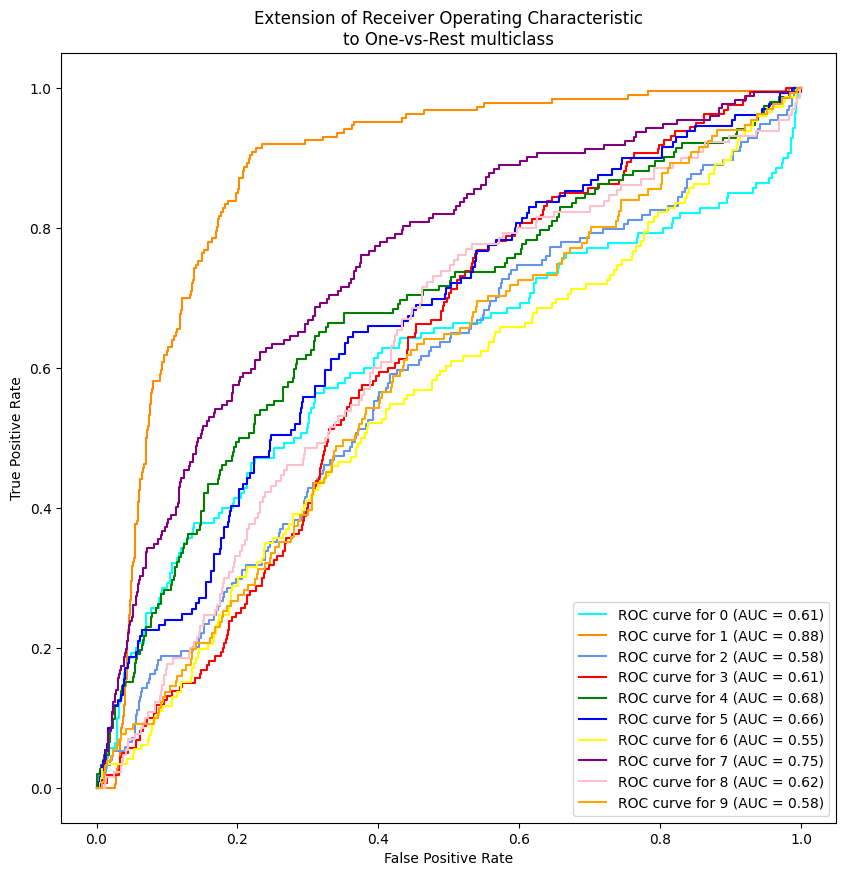

In [25]:
from itertools import cycle
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(target)
target_onehot = label_binarizer.transform(target)
predict_onehot = label_binarizer.transform(predict)

target_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
colors = cycle(["aqua", "darkorange", "cornflowerblue", "red", "green", "blue", "yellow", "purple", "pink", "orange"])

fig, ax = plt.subplots(figsize=(10, 10))

n_classes = 10
for class_id, color in zip(range(n_classes), colors):
  RocCurveDisplay.from_predictions(
        target_onehot[:, class_id],
        prob_predict[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax
    )

_ = ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass",
)

### It is possible to see that despite having achieved good metrics during the optimization process on the validation data, there is still an overfit on the test data.